In [ ]:
# import boto3
# from botocore.config import Config
# from tqdm import tqdm
# import os
# import gzip
# import shutil
# import pandas as pd

# # --- Config ---
# BUCKET = "flatfiles"
# base_dir = "agg_data/crypto/"
# os.makedirs(base_dir, exist_ok=True)

# # --- Setup from ENV ---
# s3 = boto3.client(
#     "s3",
#     aws_access_key_id=os.getenv("POLYGON_AWS_ACCESS_KEY_ID"),
#     aws_secret_access_key=os.getenv("POLYGON_AWS_SECRET_ACCESS_KEY"),
#     endpoint_url="https://files.polygon.io",
#     config=Config(signature_version="s3v4"),
# )

# # --- Step 1: Download all BTC minute aggregate files ---
# prefix = "global_crypto/minute_aggs_v1/"
# paginator = s3.get_paginator("list_objects_v2")

# for page in paginator.paginate(Bucket=BUCKET, Prefix=prefix):
#     for obj in tqdm(page.get("Contents", []), desc="Downloading BTCUSD", unit="file"):
#         key = obj["Key"]
#         fname = os.path.join(base_dir, key.split("/")[-1])
#         if not os.path.exists(fname):
#             s3.download_file(BUCKET, key, fname)

# print("✅ Download complete")




✅ Download complete


In [ ]:
# import pandas as pd
# import glob

# # all crypto minute files
# files = sorted(glob.glob("./agg_data/crypto/*.csv.gz"))

# dfs = []
# for f in files:
#     try:
#         df = pd.read_csv(f, compression="gzip")
#         btc_df = df[df["ticker"] == "X:BTC-USD"]
#         dfs.append(btc_df)
#     except Exception as e:
#         print(f"⚠️ Error reading {f}: {e}")

# btc_all = pd.concat(dfs, ignore_index=True)

# # convert timestamp
# btc_all["window_start"] = pd.to_datetime(btc_all["window_start"], unit="ns")

# btc_all.to_parquet("btc_1min_all.parquet", index=False)
# print("✅ Saved BTCUSD 1-min data to btc_1min_all.parquet")


⚠️ Error reading ./agg_data/crypto/2010-01-10.csv.gz: Not a gzipped file (b'PA')
⚠️ Error reading ./agg_data/crypto/2010-01-11.csv.gz: Not a gzipped file (b'PA')
⚠️ Error reading ./agg_data/crypto/2010-01-12.csv.gz: Not a gzipped file (b'PA')
⚠️ Error reading ./agg_data/crypto/2013-11-01.csv.gz: Not a gzipped file (b'PA')
⚠️ Error reading ./agg_data/crypto/2013-11-02.csv.gz: Not a gzipped file (b'PA')
⚠️ Error reading ./agg_data/crypto/2013-11-03.csv.gz: Not a gzipped file (b'PA')
⚠️ Error reading ./agg_data/crypto/2014-08-26.csv.gz: Not a gzipped file (b'PA')
⚠️ Error reading ./agg_data/crypto/2014-09-03.csv.gz: Not a gzipped file (b'PA')
⚠️ Error reading ./agg_data/crypto/2014-09-12.csv.gz: Not a gzipped file (b'PA')
⚠️ Error reading ./agg_data/crypto/2014-09-26.csv.gz: Not a gzipped file (b'PA')
⚠️ Error reading ./agg_data/crypto/2014-10-19.csv.gz: Not a gzipped file (b'PA')
⚠️ Error reading ./agg_data/crypto/2014-12-25.csv.gz: Not a gzipped file (b'PA')
✅ Saved BTCUSD 1-min data to

In [ ]:
# import pandas as pd
# df = pd.read_parquet("./btc_1min_all.parquet")

# # Make sure timestamps are datetime and sorted
# df["window_start"] = pd.to_datetime(df["window_start"], utc=True)
# df = df.sort_values("window_start").reset_index(drop=True)
# # Get datetime index
# idx = df["window_start"]

# # Compute diffs in minutes
# diffs = idx.diff().dt.total_seconds().div(60)

# # Find gaps
# gaps = diffs[diffs > 1]

# if gaps.empty:
#     streak_start = idx.iloc[0]
#     streak_end = idx.iloc[-1]
# else:
#     # Position of the most recent gap
#     last_gap_pos = gaps.index[-1]
#     gap_idx = idx.index.get_loc(last_gap_pos)   # ✅ fix: use Index.get_loc
#     streak_start = idx[gap_idx]                 # first ts after gap
#     streak_end = idx.iloc[-1]                   # last ts in dataset

# # Calculate streak length
# streak_minutes = int((streak_end - streak_start).total_seconds() // 60)

# print(f"Most recent contiguous streak:")
# print(f"⏱ {streak_minutes:,} minutes (~{streak_minutes/60:.2f} hours, ~{streak_minutes/1440:.2f} days)")
# print(f"📅 From {streak_start} to {streak_end}")


Most recent contiguous streak:
⏱ 2 minutes (~0.03 hours, ~0.00 days)
📅 From 2025-09-22 23:54:00+00:00 to 2025-09-22 23:56:00+00:00


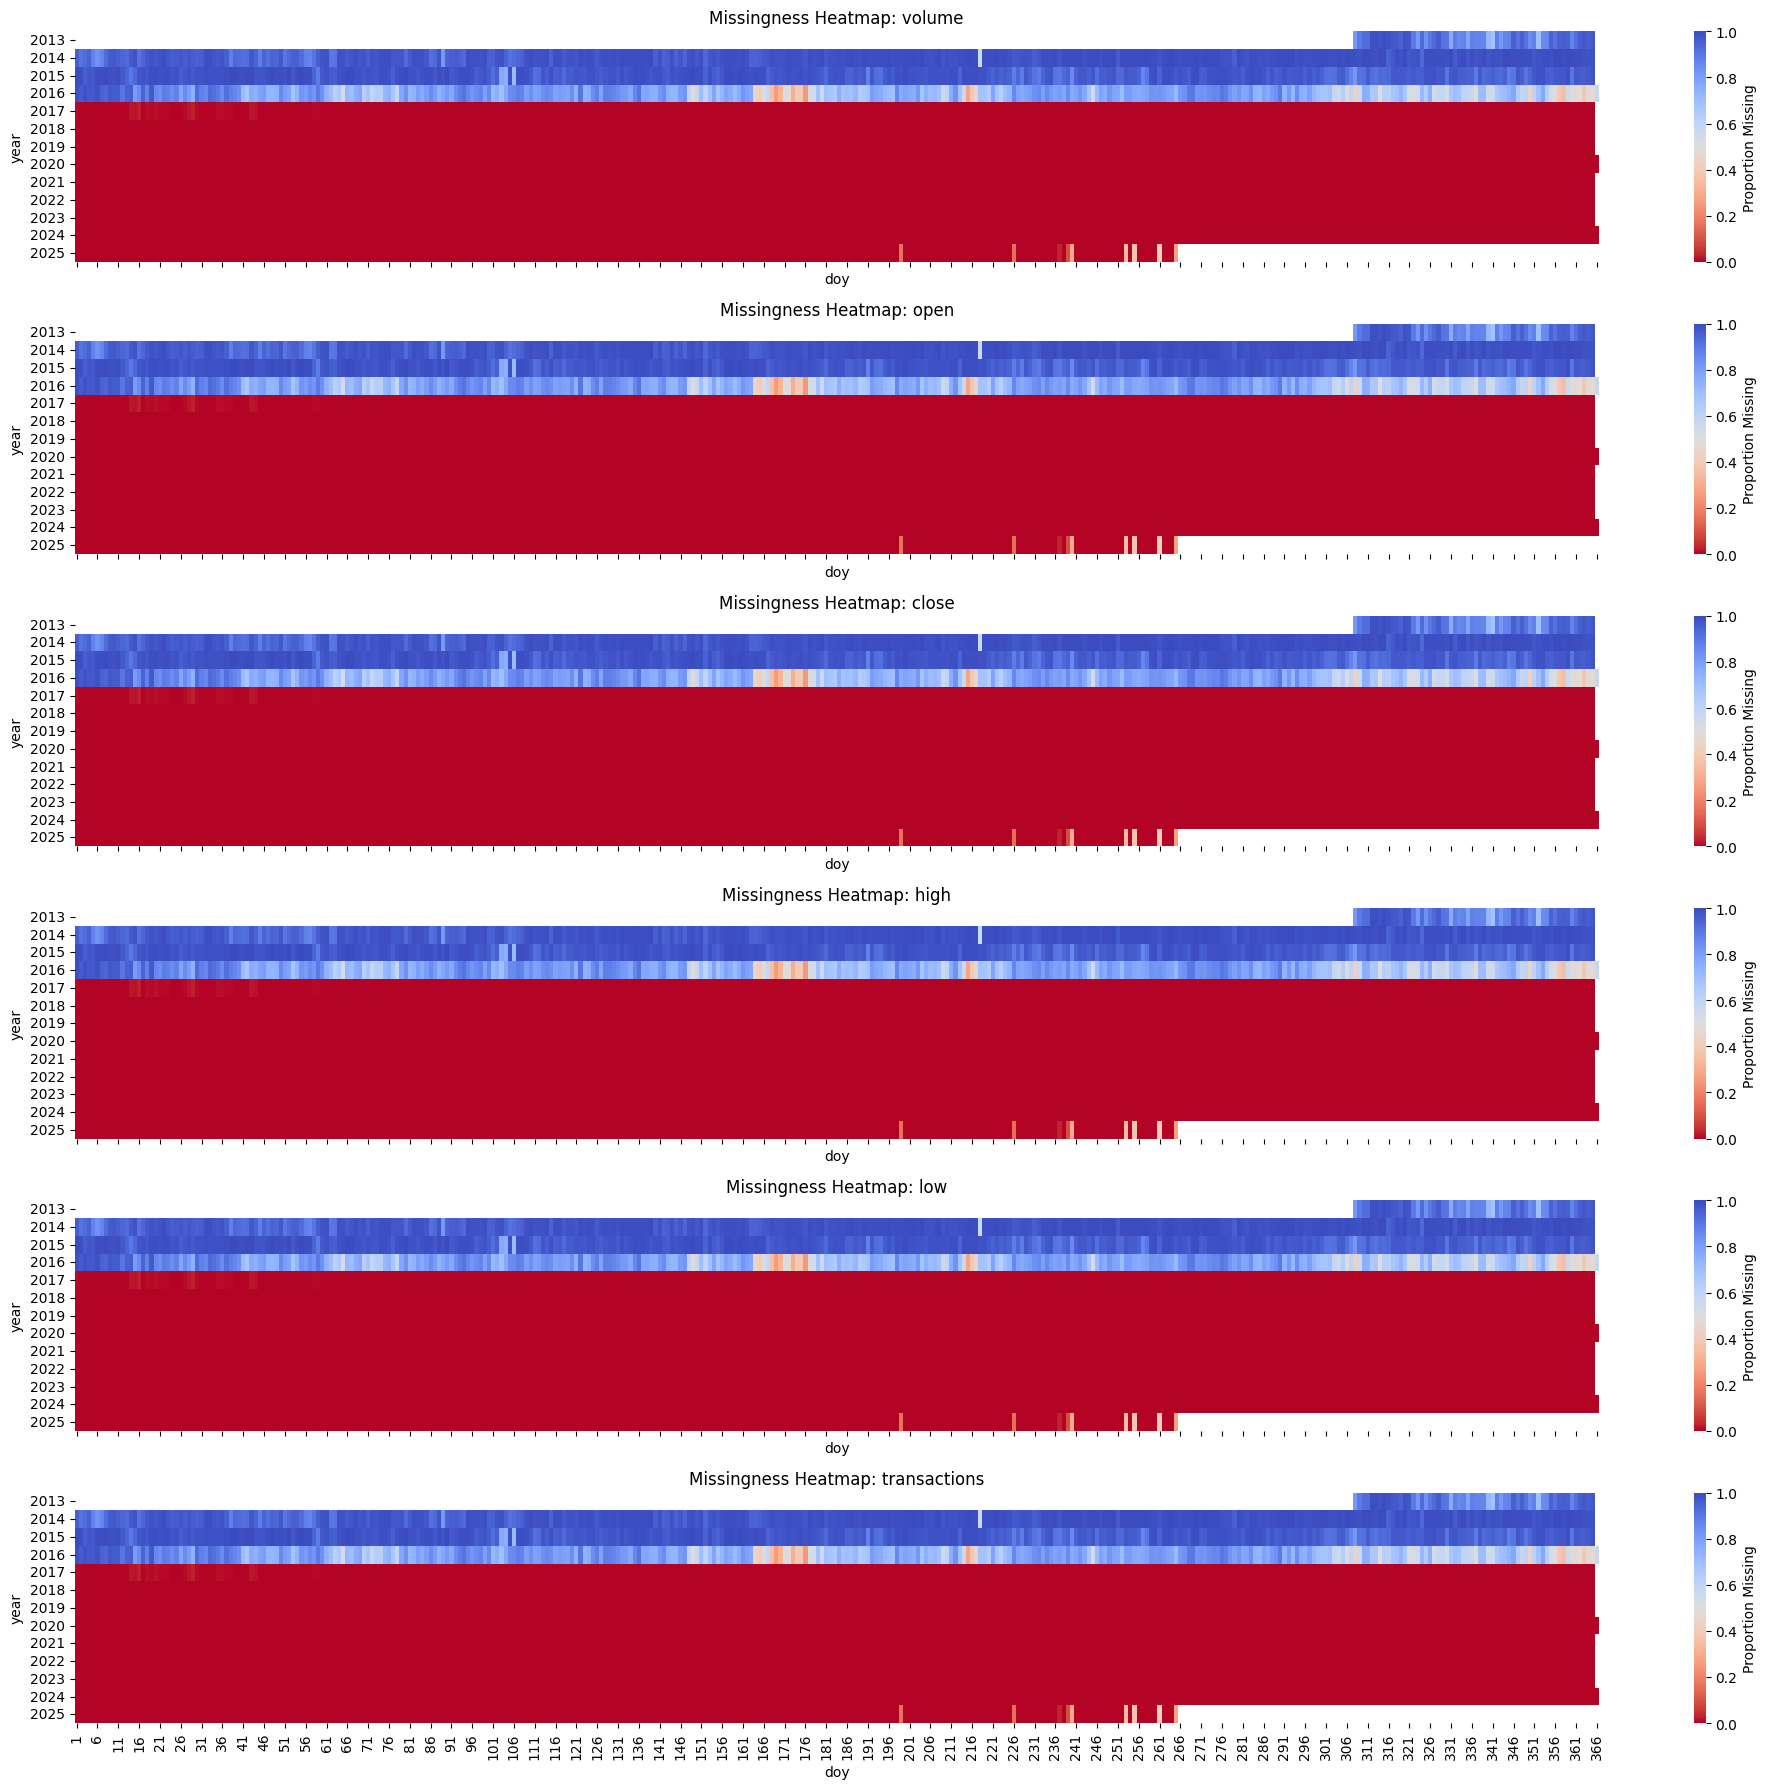

In [ ]:
# import pandas as pd
# import matplotlib.pyplot as plt
# import seaborn as sns

# # Load BTC parquet
# df = pd.read_parquet("./btc_1min_all.parquet")
# df["window_start"] = pd.to_datetime(df["window_start"], utc=True)
# df = df.sort_values("window_start")

# # Reindex to full 1-min grid
# full_idx = pd.date_range(df["window_start"].min(), df["window_start"].max(), freq="1min", tz="UTC")
# df = df.set_index("window_start").reindex(full_idx)

# # Make missingness indicator for each column
# missingness = df.isna().astype(int)

# # Resample daily mean missingness
# daily_missing = missingness.resample("1D").mean()
# daily_missing["year"] = daily_missing.index.year
# daily_missing["doy"] = daily_missing.index.dayofyear

# # One heatmap per column
# cols = [c for c in df.columns if c != "ticker"]  # skip ticker string if present
# ncols = len(cols)

# fig, axes = plt.subplots(ncols, 1, figsize=(20, 3 * ncols), sharex=True)

# if ncols == 1:
#     axes = [axes]

# for ax, col in zip(axes, cols):
#     pivot = daily_missing.pivot(index="year", columns="doy", values=col)
#     sns.heatmap(pivot, cmap="coolwarm_r", cbar_kws={"label": "Proportion Missing"}, ax=ax)
#     ax.set_title(f"Missingness Heatmap: {col}")

# plt.tight_layout()
# plt.show()


In [ ]:
# import pandas as pd

# # Load parquet
# df = pd.read_parquet("./btc_1min_all.parquet")

# # Ensure datetime and sort
# df["window_start"] = pd.to_datetime(df["window_start"], utc=True)
# df = df.sort_values("window_start")

# # Define target window
# start = "2018-01-01"
# end   = "2025-06-30"

# # Restrict to that range
# df_range = df[(df["window_start"] >= start) & (df["window_start"] <= end)].copy()

# # Build expected minute index
# expected_idx = pd.date_range(start=start, end=end, freq="1min", tz="UTC")

# # Align: keep only rows where we have data at every expected timestamp
# df_aligned = (
#     df_range.set_index("window_start")
#     .reindex(expected_idx)   # inserts NaNs for missing
#     .dropna()                # drop rows with gaps
#     .reset_index()
#     .rename(columns={"index": "window_start"})
# )

# print(f"✅ Continuous block size: {len(df_aligned)} rows")
# print(f"From {df_aligned['window_start'].min()} to {df_aligned['window_start'].max()}")

# # Save
# df_aligned.to_parquet("btc_1min_clean_2018_2025H1.parquet")


✅ Continuous block size: 3941281 rows
From 2018-01-01 00:00:00+00:00 to 2025-06-30 00:00:00+00:00


Proportion missing per column (0 = perfect, 1 = fully missing):
window_start    0.0
ticker          0.0
volume          0.0
open            0.0
close           0.0
high            0.0
low             0.0
transactions    0.0
dtype: float64


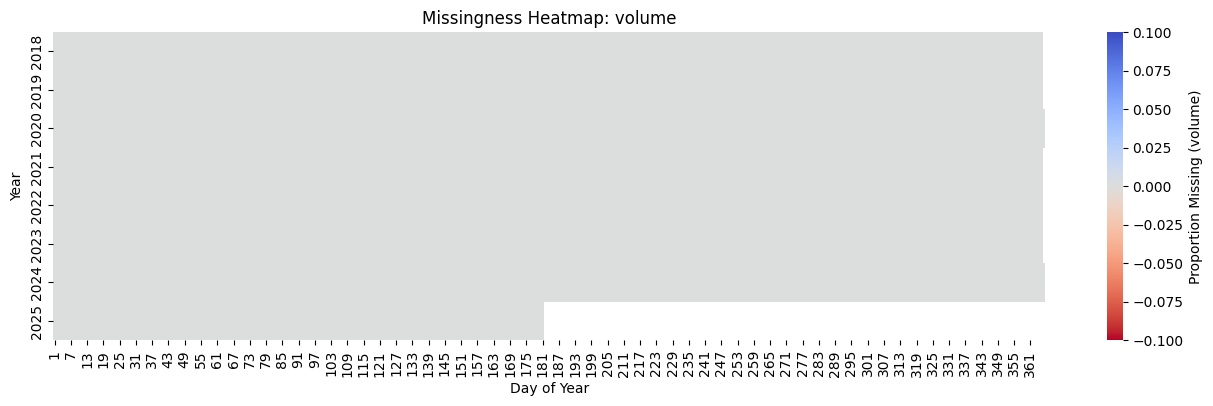

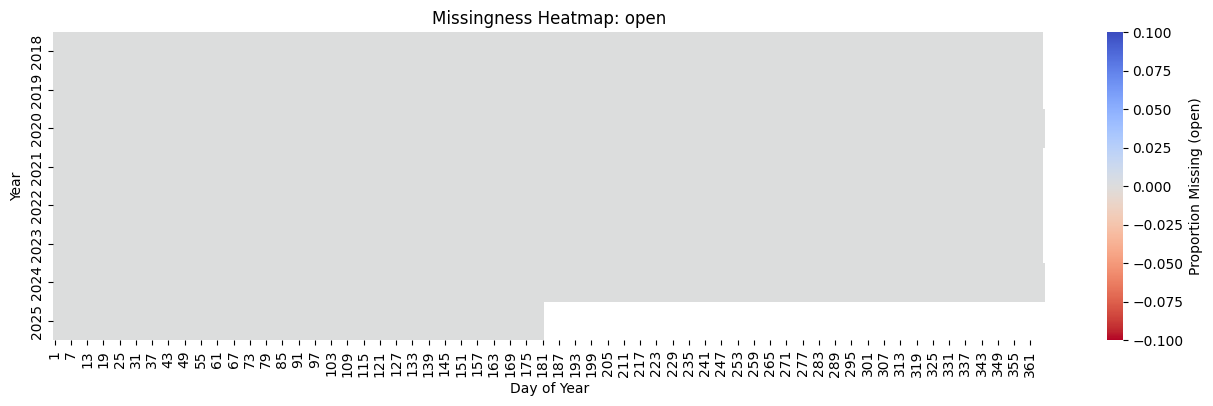

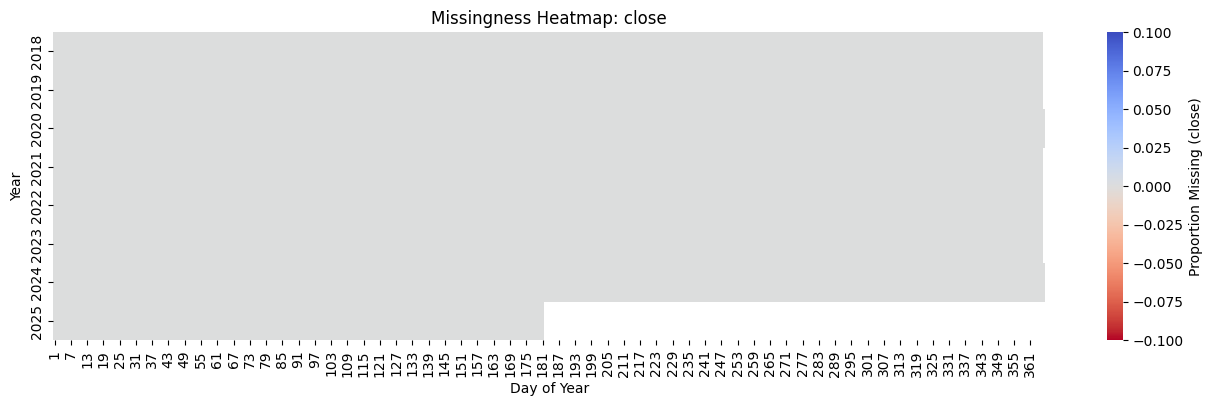

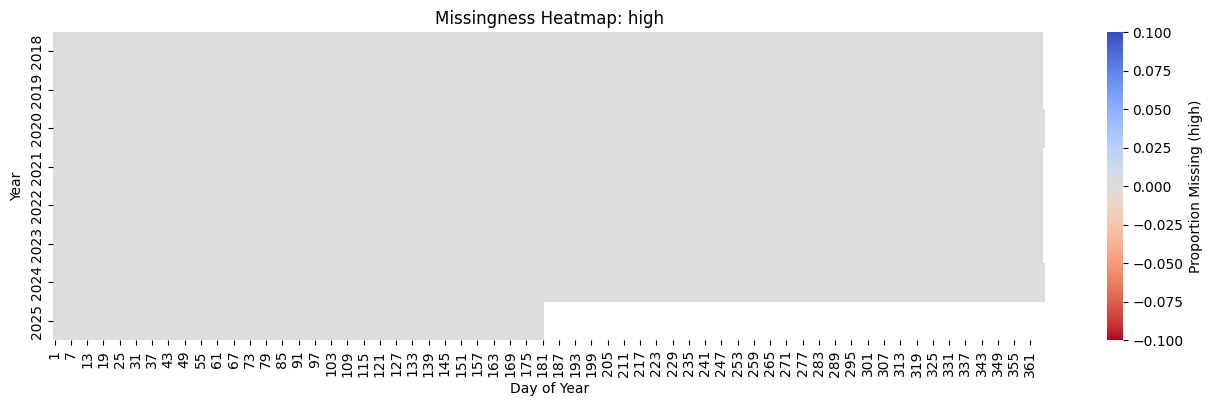

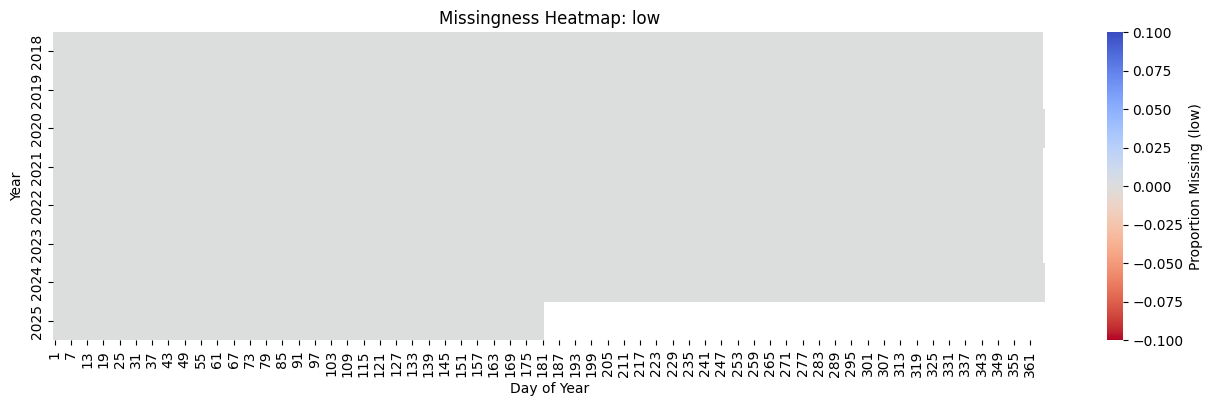

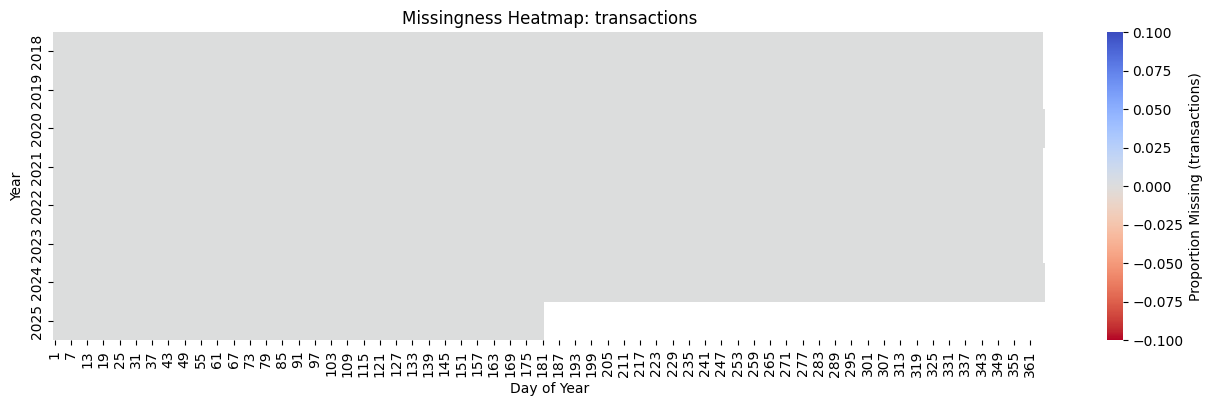

In [ ]:
# import matplotlib.pyplot as plt
# import seaborn as sns

# # Reload cleaned dataset
# df_clean = pd.read_parquet("btc_1min_clean_2018_2025H1.parquet")

# # --- Missingness summary per column ---
# missing_summary = df_clean.isna().mean().sort_values(ascending=False)
# print("Proportion missing per column (0 = perfect, 1 = fully missing):")
# print(missing_summary)

# # --- Daily missingness heatmap per column ---
# df_clean = df_clean.set_index("window_start")

# for col in ["volume", "open", "close", "high", "low", "transactions"]:
#     daily_missing = df_clean[col].isna().resample("1D").mean()

#     plt.figure(figsize=(16, 4))
#     missing_matrix = daily_missing.to_frame().assign(year=daily_missing.index.year, doy=daily_missing.index.dayofyear)
#     pivot = missing_matrix.pivot(index="year", columns="doy", values=col)

#     sns.heatmap(
#         pivot,
#         cmap="coolwarm_r",
#         cbar_kws={"label": f"Proportion Missing ({col})"},
#         linewidths=0
#     )
#     plt.title(f"Missingness Heatmap: {col}")
#     plt.xlabel("Day of Year")
#     plt.ylabel("Year")
#     plt.show()
